# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1).astype(float) / 255
x_test = x_test_pics.reshape(y_test.shape[0], -1).astype(float) / 255

4422102/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC


class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim

        self.__pca = PCA(n_components=self.new_dim) if self.use_PCA else None
        self.__W, self.__b = None, None


    def __variance_estimation(self, X):
        n_samples = int(1e6)

        first_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        second_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        uncommon_indices = np.where(first_rows != second_rows)
        
        first_rows, second_rows = first_rows[uncommon_indices], second_rows[uncommon_indices]
        pair_variances = np.sum(np.power(X[first_rows, :] - X[second_rows, :], 2), axis=1)

        return np.median(pair_variances)
    

    def fit(self, X):
        if self.use_PCA:
            X = self.__pca.fit_transform(X)
        
        sigma = np.sqrt(self.__variance_estimation(X))
        assert sigma > 1e-10, f'Error in sigma'

        self.__W = np.random.normal(scale=1 / sigma, size=(self.n_features, X.shape[1]))
        self.__b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features).reshape((1, self.n_features))

        assert not np.isnan(self.__W).any(), f'Error in W'
        assert not np.isnan(self.__b).any(), f'Error in b'

        return X


    def transform(self, X):
        if self.use_PCA:
            X = self.__pca.transform(X)
        return np.cos(X @ self.__W.T + self.__b)


    def fit_transform(self, X):
        X = self.fit(X)
        return np.cos(X @ self.__W.T + self.__b)


        


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.feature_transformer = FeatureTransformer(n_features, new_dim, use_PCA)

        if classifier != 'svm' and classifier != 'logreg':
            raise ValueError('Classifier must be either "svm" or "logreg".')

        if classifier == 'svm':
            self.classifier = LinearSVC(random_state=42)
        else:
            self.classifier = LogisticRegression(random_state=42)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X = self.feature_transformer.fit_transform(X)
        self.classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict(X)


# W @ X.T:
# (n_features * X.shape[1]) @ (X.shape[1], X.shape[0]) = (n_features * X.shape[0]) 
# nah, let's transpose
# X @ W.T:
# (X.shape[0], X.shape[1]) @ (X.shape[1], n_features) = (X.shape[0] * n_features) 
# rowwise add with b

In [4]:
from sklearn.metrics import accuracy_score

In [23]:
model = RFFPipeline()
model.fit(x_train, y_train)

predicted_test = model.predict(x_test)
score = accuracy_score(y_test, predicted_test)
print(f'Accuracy score on test: {score}')

Accuracy score on test: 0.8616


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
!pip install catboost

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC

import time

In [7]:
!pip install scikit-learn-intelex
import sklearnex
sklearnex.patch_sklearn()

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
catboost_params = {
    'CatBoost__depth': [4, 6, 8, 10],
    'CatBoost__n_estimators': [2, 4, 8, 16]
}
best_catboost_params = dict()

PCA_catboost_pipe = Pipeline([
    ('PCA', PCA(n_components=50)),
    ('CatBoost', CatBoostClassifier(verbose=False))
])


models = {
    'PCA_CatBoost': GridSearchCV(estimator=PCA_catboost_pipe, param_grid=catboost_params),
    'linear_svm': LinearSVC(),
    'kernel_svm': SVC(kernel='rbf'),
    'PCA_RFF_logreg': RFFPipeline(classifier='logreg'),
    'PCA_RFF_linear_svm': RFFPipeline(classifier='svm'),
    'RFF_logreg': RFFPipeline(use_PCA=False, classifier='logreg'),
    'RFF_linear_svm': RFFPipeline(use_PCA=False, classifier='svm')
}

In [9]:
@ignore_warnings(category=ConvergenceWarning)
def test_models(models, stats, x_train, y_train, verbose=True):
    for name, model in models.items():
        print(f'Running {name} model')

        train_start_time = time.time()
        model.fit(x_train_trunc, y_train_trunc)
        train_time = time.time() - train_start_time

        if name == 'PCA_CatBoost':
            global best_catboost_params
            best_catboost_params = model.best_params_

        predicted_test = model.predict(x_test)
        score = accuracy_score(y_test, predicted_test)

        print(f'It took {"%.2f" % train_time}, accuracy score: {score}')
        stats[name] = {'score': score, 'train_time': train_time}

In [10]:
x_train_trunc, y_train_trunc = x_train[:12000], y_train[:12000]
stats = {}

In [10]:
test_models(models, stats, x_train_trunc, y_train_trunc)

Running PCA_CatBoost model
Accuracy score on test: 0.7968
Running linear_svm model
Accuracy score on test: 0.8136
Running kernel_svm model
Accuracy score on test: 0.8577
Running PCA_RFF_logreg model
Accuracy score on test: 0.8477
Running PCA_RFF_linear_svm model
Accuracy score on test: 0.8545
Running RFF_logreg model
Accuracy score on test: 0.8437
Running RFF_linear_svm model
Accuracy score on test: 0.8241


In [11]:
test_models(models, stats, x_train_trunc, y_train_trunc)

Running PCA_CatBoost model
It took 295.90, accuracy score: 0.797
Running linear_svm model
It took 44.40, accuracy score: 0.8153
Running kernel_svm model
It took 18.18, accuracy score: 0.8577
Running PCA_RFF_logreg model
It took 8.41, accuracy score: 0.8506
Running PCA_RFF_linear_svm model
It took 87.65, accuracy score: 0.8608
Running RFF_logreg model
It took 7.92, accuracy score: 0.8441
Running RFF_linear_svm model
It took 65.04, accuracy score: 0.8228


RFF помогает, особенно вместе с PCA. По итогу метод жрёт намного меньше времени и работает на порядок лучше. Катбуст на этой задаче не оч

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [32]:
for use_PCA in [True, False]:
    model = RFFPipeline(use_PCA=use_PCA)
    
    train_start_time = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - train_start_time

    predicted_test = model.predict(x_test)
    score = accuracy_score(y_test, predicted_test)
    
    print(f'Trained for {"%.2f" % train_time} seconds with use_PCA={use_PCA}, accuracy score: {score}')

Trained for 12.24 seconds with use_PCA=True, accuracy score: 0.859
Trained for 13.53 seconds with use_PCA=False, accuracy score: 0.8614


С PCA чуть менее точно и побыстрее

In [33]:
rff_n_features_grid = np.logspace(1, 4, num=8, dtype=np.int64)
grid_scores = {}

for n_features in rff_n_features_grid:
    model = RFFPipeline(n_features=n_features)
        
    train_start_time = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - train_start_time
    
    predicted_test = model.predict(x_test)
    score = accuracy_score(y_test, predicted_test)
    
    grid_scores[n_features] = score
    
    print(f'Trained for {"%.2f" % train_time} seconds with n_features={n_features}, accuracy_score: {score}')

Trained for 1.06 seconds with n_features=10, accuracy_score: 0.6614
Trained for 1.19 seconds with n_features=26, accuracy_score: 0.7638
Trained for 1.72 seconds with n_features=71, accuracy_score: 0.8253
Trained for 2.51 seconds with n_features=193, accuracy_score: 0.8442
Trained for 4.24 seconds with n_features=517, accuracy_score: 0.8569
Trained for 14.93 seconds with n_features=1389, accuracy_score: 0.8577
Trained for 31.62 seconds with n_features=3727, accuracy_score: 0.8622
Trained for 117.93 seconds with n_features=10000, accuracy_score: 0.8612


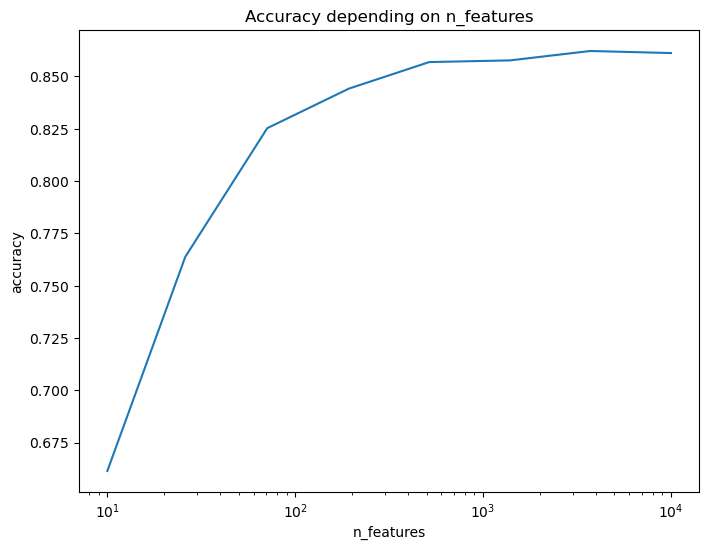

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(grid_scores.keys(), grid_scores.values())
plt.title('Accuracy depending on n_features')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.xscale('log')
plt.show()

На плато выходит, в целом n_features=1000 или скажем 800 - оптимальный с точки зрения затрат по времени вариант.

In [35]:
for clf_name in ['logreg', 'svm']:
    model = RFFPipeline(classifier=clf_name)
    
    train_start_time = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - train_start_time

    predicted_test = model.predict(x_test)
    score = accuracy_score(y_test, predicted_test)
    
    print(f'Trained for {"%.2f" % train_time} seconds with classifier={clf_name}, accuracy score: {score}')

Trained for 12.00 seconds with classifier=logreg, accuracy score: 0.8592
Trained for 504.98 seconds with classifier=svm, accuracy score: 0.8617


SVM долгий капец. Но чуть поточнее

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [64]:
class OrthogonalFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim

        self.__pca = PCA(n_components=self.new_dim) if self.use_PCA else None
        self.__W, self.__b = None, None


    def __variance_estimation(self, X):
        n_samples = int(1e6)

        first_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        second_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        uncommon_indices = np.where(first_rows != second_rows)
        
        first_rows, second_rows = first_rows[uncommon_indices], second_rows[uncommon_indices]
        pair_variances = np.sum(np.power(X[first_rows, :] - X[second_rows, :], 2), axis=1)

        return np.median(pair_variances)
    
    
    def __compute_partial_W(self):
        S = np.sqrt(np.random.chisquare(self.n_features, self.n_features))
        G = np.random.normal(size=(self.n_features, self.n_features))
        Q, _ = np.linalg.qr(G)
        W = S * Q
        return W
        

    def fit(self, X):
        if self.use_PCA:
            X = self.__pca.fit_transform(X)
        
        sigma = np.sqrt(self.__variance_estimation(X))

        self.__W = np.concatenate([
            self.__compute_partial_W() for _ in range(0, X.shape[1], self.n_features)
        ], axis=1) / sigma
        
        if self.n_features > X.shape[1]:
            self.__W = self.__W[:, :X.shape[1]]
            
        self.__b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features).reshape((1, self.n_features))
        return X


    def transform(self, X):
        if self.use_PCA:
            X = self.__pca.transform(X)
        return np.cos(X @ self.__W.T + self.__b)


    def fit_transform(self, X):
        X = self.fit(X)
        return np.cos(X @ self.__W.T + self.__b)


        

class ORFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.feature_transformer = OrthogonalFeatureTransformer(n_features, new_dim, use_PCA)

        if classifier != 'svm' and classifier != 'logreg':
            raise ValueError('Classifier must be either "svm" or "logreg".')

        if classifier == 'svm':
            self.classifier = LinearSVC(random_state=42)
        else:
            self.classifier = LogisticRegression(random_state=42)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X = self.feature_transformer.fit_transform(X)
        self.classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict(X)
    

# W @ X.T:
# (n_features * X.shape[1]) @ (X.shape[1], X.shape[0]) = (n_features * X.shape[0]) 
# nah, let's transpose
# X @ W.T:
# (X.shape[0], X.shape[1]) @ (X.shape[1], n_features) = (X.shape[0] * n_features) 
# rowwise add with b

In [70]:
print('Original case')
model = ORFFPipeline()

train_start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - train_start_time

score = accuracy_score(y_test, model.predict(x_test))
print(f'Took {"%.2f" % train_time} seconds, accuracy score: {score}')

Original case
Took 11.79 seconds, accuracy score: 0.8578


In [69]:
print('Orthogonal case')
model_orth = ORFFPipeline()

train_start_time = time.time()
model_orth.fit(x_train, y_train)
train_time = time.time() - train_start_time

score = accuracy_score(y_test, model_orth.predict(x_test))
print(f'Took {"%.2f" % train_time} seconds, accuracy score: {score}')

Orthogonal case
Took 12.42 seconds, accuracy score: 0.8582


__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
class GeneralFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, 
                 orthogonal=False, transform_function=np.cos):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.orthogonal = orthogonal
        self.transform_function = transform_function

        self.__pca = PCA(n_components=self.new_dim) if self.use_PCA else None
        self.__W, self.__b = None, None


    def __variance_estimation(self, X):
        n_samples = int(1e6)

        first_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        second_rows = np.random.choice(X.shape[0], size=min(X.shape[0], n_samples), replace=False)
        uncommon_indices = np.where(first_rows != second_rows)
        
        first_rows, second_rows = first_rows[uncommon_indices], second_rows[uncommon_indices]
        pair_variances = np.sum(np.power(X[first_rows, :] - X[second_rows, :], 2), axis=1)

        return np.median(pair_variances)
    
    
    def __compute_partial_W(self):
        S = np.sqrt(np.random.chisquare(self.n_features, self.n_features))
        G = np.random.normal(size=(self.n_features, self.n_features))
        Q, _ = np.linalg.qr(G)
        W = S * Q
        return W
        

    def fit(self, X):
        if self.use_PCA:
            X = self.__pca.fit_transform(X)
        
        sigma = np.sqrt(self.__variance_estimation(X))

        if not self.orthogonal:
            self.__W = np.random.normal(scale=1 / sigma, size=(self.n_features, X.shape[1]))
        else:
            self.__W = np.concatenate([
                self.__compute_partial_W() for _ in range(0, X.shape[1], self.n_features)
            ], axis=1) / sigma

            if self.n_features > X.shape[1]:
                self.__W = self.__W[:, :X.shape[1]]
        
        self.__b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features).reshape((1, self.n_features))
        return X


    def transform(self, X):
        if self.use_PCA:
            X = self.__pca.transform(X)
        return self.transform_function(X @ self.__W.T + self.__b)


    def fit_transform(self, X):
        X = self.fit(X)
        return self.transform_function(X @ self.__W.T + self.__b)


        

class GeneralRFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, 
                 orthogonal=False, transform_function=np.cos, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm', 'logreg' or 'gb',
        a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.feature_transformer = GeneralFeatureTransformer(
            n_features, new_dim, use_PCA, orthogonal, transform_function
        )

        if classifier not in ['svm', 'logreg', 'gb']:
            raise ValueError('Classifier must be either "svm" "logreg" or "gb".')

        if classifier == 'svm':
            self.classifier = LinearSVC(random_state=42)
        elif classifier == 'logreg':
            self.classifier = LogisticRegression(random_state=42)
        else:
            self.classifier = GradientBoostingClassifier(random_state=42)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X = self.feature_transformer.fit_transform(X)
        self.classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.feature_transformer.transform(X)
        return self.classifier.predict(X)

In [79]:
print('Training ORFF-logreg with different transform functions')

transform_functions = {
    'cos': np.cos,
    'sign': np.sign,
    'cos^3': lambda x: np.power(np.cos(x), 3),
    'cos^5': lambda x: np.power(np.cos(x), 5)
}

for name, transform_function in transform_functions.items():
    print(f'Now with {name} transform function...')
    model = GeneralRFFPipeline(orthogonal=True, transform_function=transform_function)

    train_start_time = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - train_start_time

    score = accuracy_score(y_test, model.predict(x_test))
    print(f'Took {"%.2f" % train_time} seconds, accuracy score: {score}')

Training ORFF-logreg with different transform functions
Now with cos transform function...
Took 12.60 seconds, accuracy score: 0.8594
Now with sign transform function...
Took 11.58 seconds, accuracy score: 0.8247
Now with cos^3 transform function...
Took 13.80 seconds, accuracy score: 0.8636
Now with cos^5 transform function...
Took 13.99 seconds, accuracy score: 0.8683


Меня порадовало, как рандомный косинус в степени  выбил хорошую точность :))))

Заметил, что точность на cos^3 и cos^5 сильно скачет на разных запусках - лучше то один, то второй. 
Все 3 запуска на полной выборке были существенно лучше обычного косинуса. 
Если запускать на обрезанной выборке - обычный косинус лучше. Интересно, почему так получается...

Дальше сравниваю logreg | SVM | GB на выборке размера 0.2 от изначальной.

In [15]:
def test_classifier_with_transform_functions(classifier):
    print(f'Training ORFF-{classifier} with different transform functions on truncated dataset')

    transform_functions = {
        'cos': np.cos,
        'sign': np.sign,
        'cos^3': lambda x: np.power(np.cos(x), 3),
        'cos^5': lambda x: np.power(np.cos(x), 5)
    }

    for name, transform_function in transform_functions.items():
        print(f'Now with {name} transform function...')

        model = GeneralRFFPipeline(
            classifier=classifier, orthogonal=True,
            transform_function=transform_function
        )

        train_start_time = time.time()
        model.fit(x_train_trunc, y_train_trunc)
        train_time = time.time() - train_start_time

        score = accuracy_score(y_test, model.predict(x_test))
        print(f'Took {"%.2f" % train_time} seconds, accuracy score: {score}')

In [87]:
test_classifier_with_transform_functions('logreg')

Training ORFF-logreg with different transform functions on truncated dataset
Now with cos transform function...
Took 2.81 seconds, accuracy score: 0.8533
Now with sign transform function...
Took 2.64 seconds, accuracy score: 0.8109
Now with cos^3 transform function...
Took 3.14 seconds, accuracy score: 0.8518
Now with cos^5 transform function...
Took 3.06 seconds, accuracy score: 0.842


In [88]:
test_classifier_with_transform_functions('svm')
# свм стабильно похуже и медленный, еще на нём не работают cos^3 | cos^5 :(((

Training ORFF-svm with different transform functions on truncated dataset
Now with cos transform function...
Took 76.32 seconds, accuracy score: 0.8483
Now with sign transform function...
Took 92.84 seconds, accuracy score: 0.7776
Now with cos^3 transform function...
Took 57.95 seconds, accuracy score: 0.832
Now with cos^5 transform function...
Took 51.65 seconds, accuracy score: 0.8321


In [ ]:
test_classifier_with_transform_functions('gb')
# гб оч медленный, я не дождался

Training ORFF-gb with different transform functions on truncated dataset
Now with cos transform function...
